In [274]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
import re

In [275]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Load the data

In [550]:
data_dir = os.path.abspath('../data')
data_path = os.path.join(data_dir, 'dfD_300s.hdf')

In [551]:
raw_input_df = pd.read_hdf(data_path)

In [552]:
raw_input_df

,D_audio_wlan_og_power,D_dishwasher_power,D_exp_power,D_hp_power,D_total_cons_power,D_rainwater_power,D_tumble_dryer_power,D_washing_machine_power
2016-04-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-23 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-23 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-23 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-23 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-07-30 23:40:00,13.814,0.0,0.0,0.0,580.0,6.756,80.6200,0.0
2019-07-30 23:45:00,13.590,0.0,0.0,0.0,585.0,6.594,79.3520,0.0
2019-07-30 23:50:00,13.740,0.0,0.0,0.0,580.0,6.588,79.0600,0.0
2019-07-30 23:55:00,13.716,0.0,0.0,0.0,555.0,6.606,78.5340,0.0


In [553]:
column_mapping = {}
for c in raw_input_df.columns:
    if c in column_mapping:
        continue
    m = re.match(r'^[A-Z]_(\w+)$', c)
    if m is None:
        raise RuntimeError('Unsupported column name format {}. You will have to map the column manually.'.format(c))
    if m[1] == 'prod_power':
        column_mapping[c] = 'exp_power'
    else:
        column_mapping[c] = m[1]
input_df = raw_input_df.rename(columns=column_mapping)
input_df.columns

Index(['audio_wlan_og_power', 'dishwasher_power', 'exp_power', 'hp_power',
       'total_cons_power', 'rainwater_power', 'tumble_dryer_power',
       'washing_machine_power'],
      dtype='object')

In [554]:
appliance_column = 'washing_machine_power'
test_day = '2018-11-27'

In [555]:
all_appliance_columns = sorted({'dishwasher_power', 'washing_machine_power', 'tumble_dryer_power'} & set(input_df.columns))
all_appliance_columns

['dishwasher_power', 'tumble_dryer_power', 'washing_machine_power']

# Vizualize a day of data

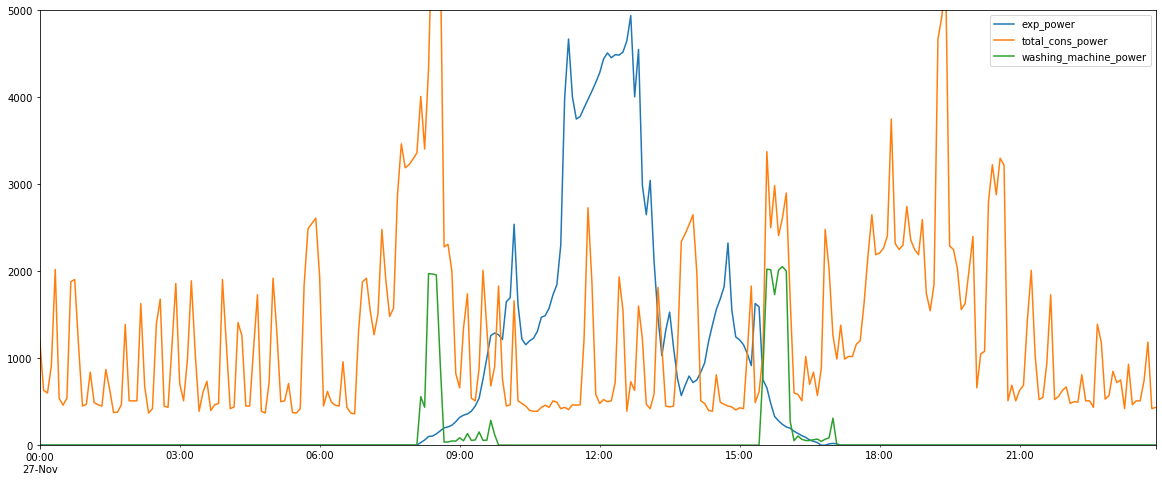

In [556]:
appliance_column = 'washing_machine_power'
test_day = '2017-11-27'
test_day_df = input_df[test_day]
test_day_df.plot(y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 8), ylim=(0, 5000))

In [557]:
appliance_series = test_day_df[appliance_column]
print(len(appliance_series))

288


# Detect appliance active areas
Figure out how to detect the rough regions in time when appliances are used

## Experiment

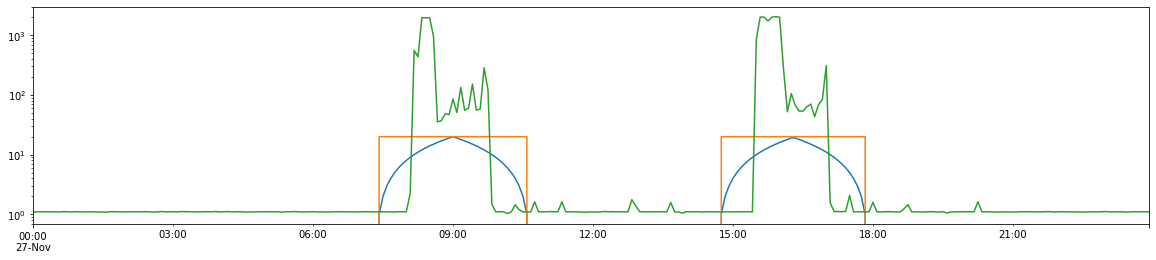

In [558]:
window_size = 20

rolling_series = (appliance_series > 30).rolling(window_size, center=True).sum()
active_areas_series = (rolling_series > 0)

plt.figure(figsize=(20, 4))
plt.yscale('log')
rolling_series.plot()
(active_areas_series * window_size).plot()
appliance_series.plot()
plt.show()

In [559]:
temp = active_areas_series.astype('int8').diff()
active_areas = list(grouper(temp.index[(temp == 1) | (temp == -1)], n=2))
active_areas

[(Timestamp('2017-11-27 07:25:00'), Timestamp('2017-11-27 10:40:00')),
 (Timestamp('2017-11-27 14:45:00'), Timestamp('2017-11-27 17:55:00'))]

## Implement

In [560]:
def narrow_active_area(active_mask, active_area):
    start, end = active_area
    active_mask = active_mask[start:end]
    return active_mask[active_mask == True].index[0], active_mask[active_mask == True].index[-1]

# TODO The returned areas could be made narrower (they currently have some zeros at the start and end)
def detect_active_areas(input_series, window_size = 20, greater_than=50, narrow=True):
    active_mask = input_series > greater_than
    temp = active_mask.rolling(window_size, center=True).sum()
    temp = temp > 0
    temp = temp.astype('int8').diff()
    areas = grouper(temp.index[(temp == 1) | (temp == -1)], n=2)
    if not narrow:
        return list(areas)
    areas = (narrow_active_area(active_mask, a) for a in areas)
    areas = ((a, b) for a, b in areas if a != b)
    return list(areas)

## Test

In [561]:
detect_active_areas(appliance_series)

[(Timestamp('2017-11-27 08:10:00'), Timestamp('2017-11-27 09:45:00')),
 (Timestamp('2017-11-27 15:30:00'), Timestamp('2017-11-27 17:00:00'))]

In [562]:
detect_active_areas(appliance_series, narrow=False)

[(Timestamp('2017-11-27 07:25:00'), Timestamp('2017-11-27 10:40:00')),
 (Timestamp('2017-11-27 14:45:00'), Timestamp('2017-11-27 17:55:00'))]

(Timestamp('2017-11-27 15:30:00', freq='300S'), Timestamp('2017-11-27 17:00:00', freq='300S'))


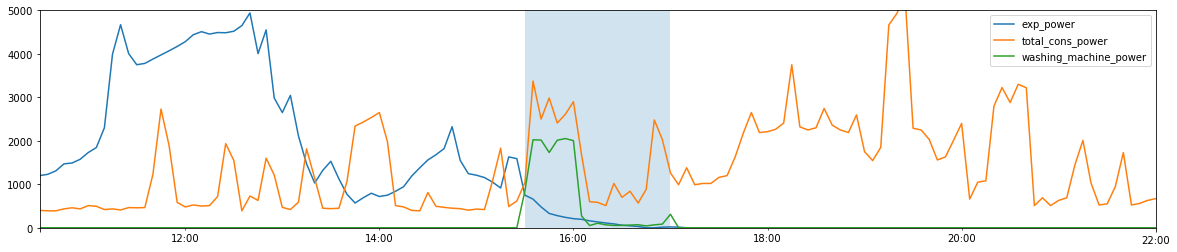

In [563]:
active_area = random.choice(detect_active_areas(appliance_series, greater_than=30))
print(active_area)
preview_area = (active_area[0] - pd.Timedelta(5, 'h'), active_area[1] + pd.Timedelta(5, 'h'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)

# Analyze appliance usage

In [564]:
all_appliance_active_areas = detect_active_areas(input_df[appliance_column], window_size=20, greater_than=30)
print("Appliance used {} times in {} days".format(len(all_appliance_active_areas), (input_df.index[-1] - input_df.index[0]).days))

Appliance used 320 times in 1194 days


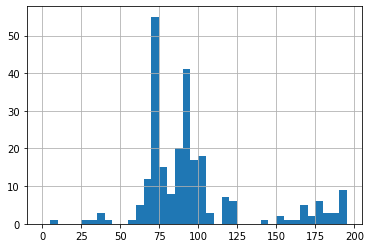

In [565]:
durations_series = pd.Series(b - a for a, b in all_appliance_active_areas)
durations_series.astype('timedelta64[m]').hist(bins=range(0, 200, 5))

In [566]:
durations_series.median()

Timedelta('0 days 01:30:00')

In [567]:
appliance_active_mask = np.logical_or.reduce(list((input_df.index >= a) & (input_df.index <= b) for a, b in all_appliance_active_areas))
print("Appliance active {:.2f}% of the time".format(100 * appliance_active_mask.sum() / len(input_df)))

Appliance active 2.66% of the time


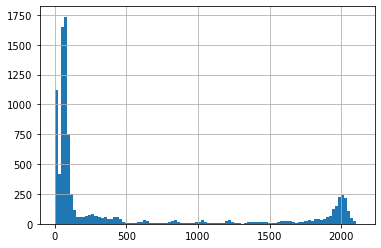

In [568]:
input_df[appliance_active_mask][appliance_column].hist(bins=100)

# Look at time between two washes

## Single example

In [569]:
active_area = next((a, b) for a, b in all_appliance_active_areas if a > pd.Timestamp('2018-01-06'))
print(active_area)
next_active_area = next((a, b) for a, b in all_appliance_active_areas if a > active_area[1])
print(next_active_area)

(Timestamp('2018-01-08 14:40:00'), Timestamp('2018-01-08 18:00:00'))
(Timestamp('2018-01-09 08:55:00', freq='300S'), Timestamp('2018-01-09 10:05:00', freq='300S'))


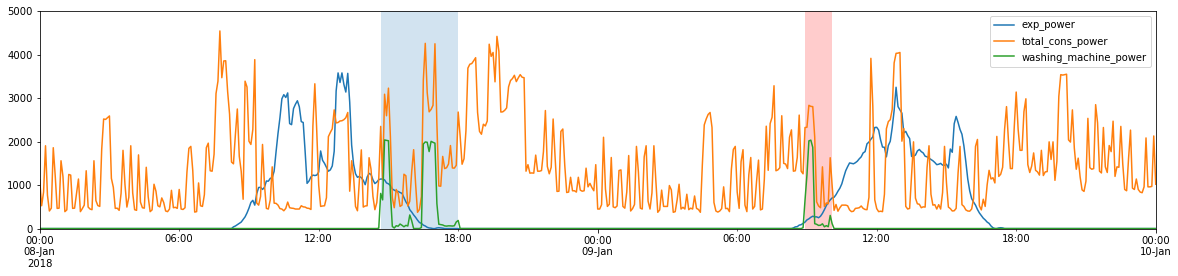

In [570]:
preview_area = (active_area[0].floor('d'), active_area[0].ceil('d') + pd.Timedelta(1, 'd'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)
p.axvspan(next_active_area[0], next_active_area[1], alpha=0.2, facecolor='red')

## Same for all washes

In [651]:
temp = (x for a in all_appliance_active_areas for x in a)
next(temp)
washes_df = pd.DataFrame(data={
    'start': (a for a, b in all_appliance_active_areas[:-1]),
    'end': (b for a, b in all_appliance_active_areas[:-1]),
    'trailing_gap': (b - a for a, b in grouper(temp, n=2) if b is not None),
})
print("Found {} gaps between {} washes".format(len(washes_df), len(all_appliance_active_areas)))

Found 319 gaps between 320 washes


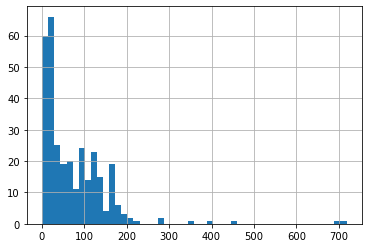

In [572]:
washes_df['trailing_gap'].astype('timedelta64[h]').hist(bins=50)

In [573]:
print(washes_df.trailing_gap.min())
print(washes_df.trailing_gap.median())
print(washes_df.trailing_gap.max())

0 days 01:45:00
1 days 23:05:00
29 days 22:35:00


In [574]:
latest_end = washes_df.end + washes_df.trailing_gap
usefully_shiftable_mask = (washes_df.end.dt.hour <= 12) & ((latest_end.dt.hour >= 17) | (latest_end.dt.day > washes_df.end.dt.day))
usefully_shiftable_mask.sum()

116

In [575]:
washes_df[usefully_shiftable_mask].sample(10)

,start,end,trailing_gap
94,2017-06-24 07:45:00,2017-06-24 09:10:00,1 days 01:30:00
108,2017-08-26 09:00:00,2017-08-26 10:10:00,2 days 23:20:00
41,2017-01-12 08:15:00,2017-01-12 09:20:00,3 days 02:40:00
122,2017-10-03 07:55:00,2017-10-03 09:20:00,0 days 22:10:00
236,2018-10-21 09:35:00,2018-10-21 11:05:00,2 days 20:10:00
7,2016-10-18 11:45:00,2016-10-18 12:45:00,4 days 03:05:00
109,2017-08-29 09:30:00,2017-08-29 11:25:00,0 days 20:25:00
154,2017-12-29 10:00:00,2017-12-29 11:35:00,1 days 01:25:00
238,2018-10-24 10:55:00,2018-10-24 12:25:00,4 days 20:05:00
172,2018-03-05 08:40:00,2018-03-05 11:30:00,4 days 22:40:00


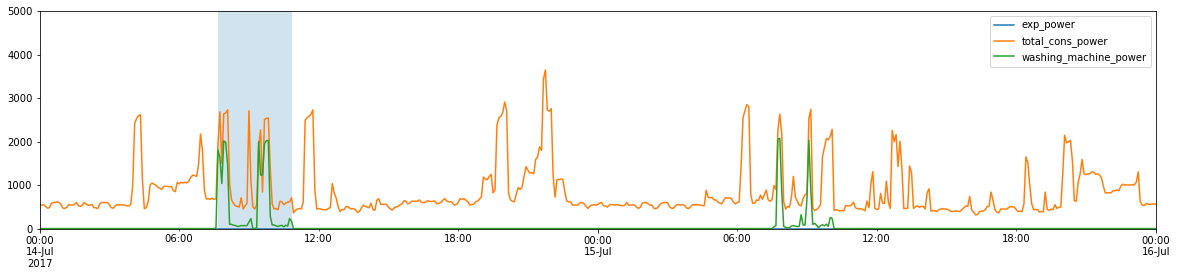

In [576]:
active_area = washes_df[usefully_shiftable_mask].sample().iloc[0]
preview_area = (pd.Timestamp(active_area.start).floor('d'), pd.Timestamp(active_area.start).ceil('d') + pd.Timedelta(1, 'd'))
p = input_df[preview_area[0]:preview_area[1]].plot(kind='line', y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area.start, active_area.end, alpha=0.2)

# Calculate PV self-consumption

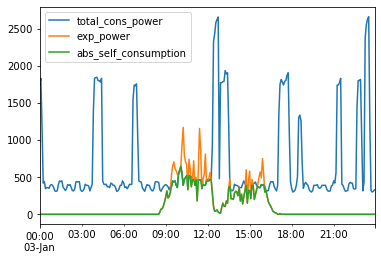

In [577]:
self_consumption_df = input_df.assign(abs_self_consumption=input_df[['total_cons_power', 'exp_power']].min(axis=1))
test_day_df = self_consumption_df['2018-01-03']
test_day_df[['total_cons_power', 'exp_power', 'abs_self_consumption']].plot()

In [578]:
print('Self-consumption for example day: {:.2f}%'.format(100 * test_day_df.abs_self_consumption.sum() / test_day_df.exp_power.sum()))
print('Self-consumption for all days: {:.2f}%'.format(100 * self_consumption_df.abs_self_consumption.sum() / self_consumption_df.exp_power.sum()))

Self-consumption for example day: 79.79%
Self-consumption for all days: 25.39%


[]

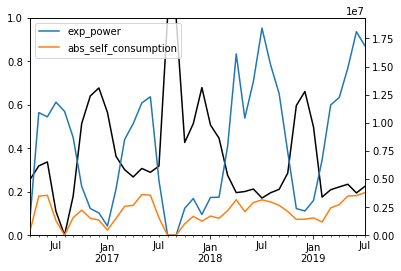

In [579]:
grouped = self_consumption_df.groupby(pd.Grouper(freq='M')).sum()

fig, ax1 = plt.subplots()
ax1.set_ylim(0, 1)
(grouped.abs_self_consumption / grouped.exp_power).plot(ax=ax1, color='black')
grouped[['exp_power', 'abs_self_consumption']].plot(ax=ax1.twinx(), ylim=0)
plt.plot()

In [580]:
def calc_self_consumption(df, consumed_column='total_cons_power', produced_column='exp_power'):
    return df[[consumed_column, produced_column]].min(axis=1).sum() / df[produced_column].sum()

print('Self-consumption for all days (using helper function): {:.2f}%'.format(100 * calc_self_consumption(input_df)))

Self-consumption for all days (using helper function): 25.39%


# Shift a single chunk of load

In [581]:
test_day_df = input_df[test_day]
active_area = (pd.Timestamp(test_day + ' 06:30:00'), pd.Timestamp(test_day + ' 07:10:00'))

In [582]:
def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))
    p.axvspan(active_area[0], active_area[1], alpha=0.2)

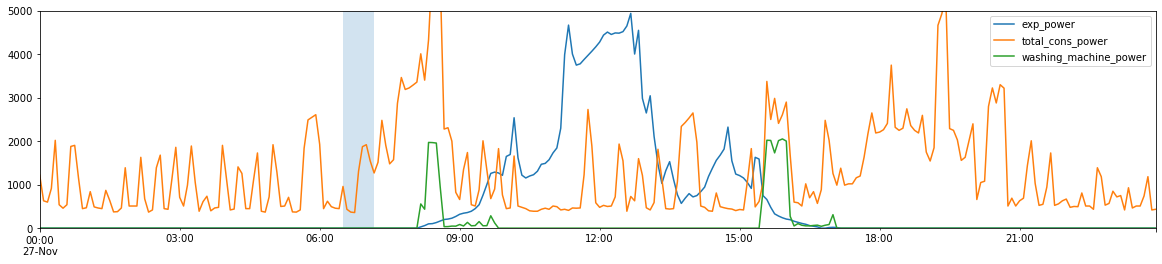

In [583]:
temp_plot(test_day_df)

In [584]:
active_mask = (test_day_df.index >= active_area[0]) & (test_day_df.index <= active_area[1])
print('Active for {} of {} periods'.format(active_mask.sum(), len(active_mask)))

Active for 9 of 288 periods


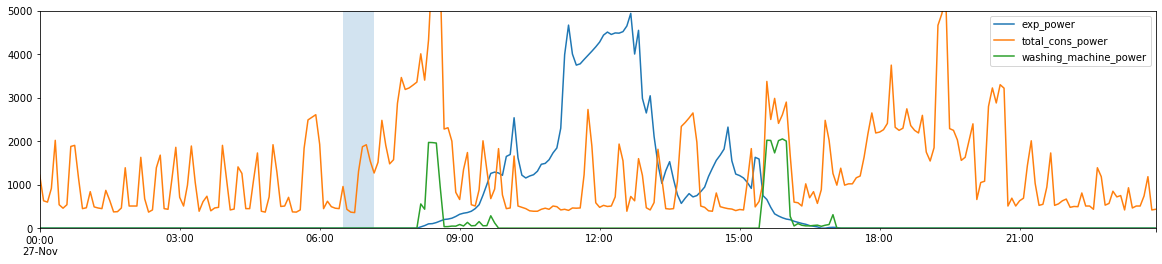

In [585]:
modified_df = test_day_df.copy()
modified_df.loc[active_mask, 'total_cons_power'] -= test_day_df[appliance_column]
modified_df.loc[active_mask, appliance_column] = 0
temp_plot(modified_df)

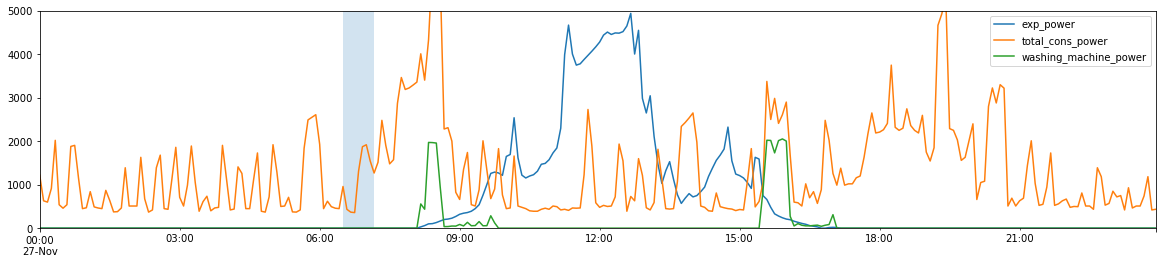

In [586]:
shifted = test_day_df.loc[active_mask, appliance_column].tshift(periods=25)
modified_df[appliance_column] = modified_df[appliance_column].add(shifted, fill_value=0)
modified_df.total_cons_power = modified_df.total_cons_power.add(shifted, fill_value=0)
temp_plot(modified_df)

In [587]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(100 * calc_self_consumption(test_day_df), 100 * calc_self_consumption(modified_df)))

Self-consumption improved from 35.10% to 35.10%


# Shift all load in a naive way
Move every wash to start at midday (on the same day), or to finish right before the next wash (whatever is earlier)

In [588]:
def get_educated_shifts(df, actions_df, appliance_column, total_column='total_cons_power',exp_column='exp_power'):
    search_ends = np.minimum(actions_df.end+actions_df.trailing_gap, actions_df.start.dt.floor('D') + pd.Timedelta(24, 'hours'))
    unused_pv = df[exp_column] - df[total_column]
    unused_pv.loc[unused_pv<0]=0
    serch_df = actions_df.assign(search_end=search_ends)
    shifts = []
    new_end = df.index[0]
    for row in serch_df.itertuples():
        search_start = np.maximum(new_end,row.start.floor('D'))
        search_mask = (df.index >= search_start) & (df.index <= row.search_end)
        active_mask = (df.index >= row.start) & (df.index <= row.end)
        shift = np.correlate(unused_pv.loc[search_mask],df[appliance_column][active_mask]).argmax()
        if shift != 0:
            shift = (shift + (search_start-row.start)/df.index.freq).astype('int32')
        shifts.append(shift)
        new_end = row.end+pd.Timedelta(shift*df.index.freq)
    return pd.Series(shifts)

def apply_shift(df, shift_df, total_column, appliance_column):
    df = df.copy()
    for row in shift_df.itertuples():
        if not row.shift_periods:
            continue
        active_mask = (df.index >= row.start) & (df.index <= row.end)
        shifted = df.loc[active_mask, appliance_column].tshift(periods=row.shift_periods)
        df.loc[active_mask, total_column] -= df[appliance_column]
        df.loc[active_mask, appliance_column] = 0
        df[appliance_column] = df[appliance_column].add(shifted, fill_value=0)
        df[total_column] = df[total_column].add(shifted, fill_value=0)
    return df

In [589]:
# temp = np.maximum(washes_df.start, washes_df.start.dt.floor('D') + pd.Timedelta(12, 'hours'))
# temp = np.minimum(washes_df.trailing_gap, temp - washes_df.start) / input_df.index.freq
# shift_df = washes_df.assign(shift_periods=np.floor(temp).astype('int32'))
shift_df = washes_df.assign(shift_periods=get_educated_shifts(input_df,washes_df,appliance_column))
print("{} of {} washes will be shifted".format((shift_df.shift_periods > 0).sum(), len(shift_df)))

182 of 319 washes will be shifted


In [590]:
modified_df = apply_shift(input_df, shift_df, 'total_cons_power', appliance_column)

In [591]:
print(*(d[appliance_column].sum() for d in [input_df, modified_df]))

4709194.439303031 4709194.439303031


In [592]:
def temp_plot(df):
    p = df[['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))

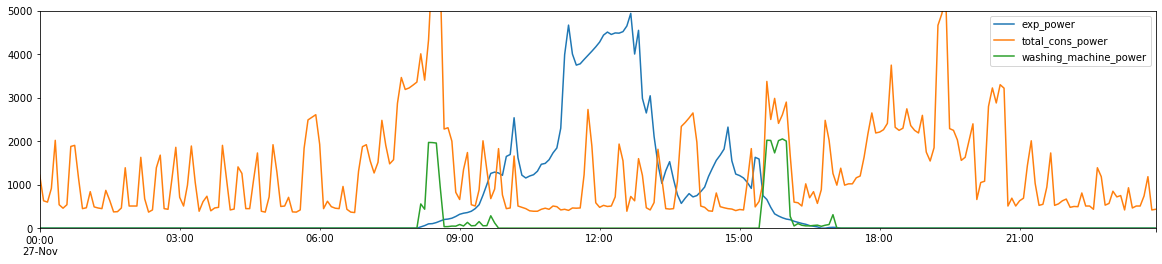

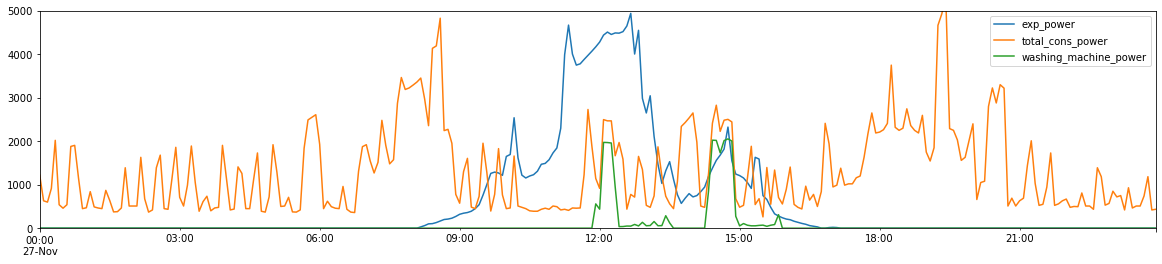

In [593]:
test_day_df = input_df[test_day]
test_day_modified_df = modified_df[test_day]
temp_plot(test_day_df)
temp_plot(test_day_modified_df)

In [594]:
print("Self-consumption improved from {:.2f}% to {:.2f}%".format(*(100 * calc_self_consumption(d) for d in [input_df, modified_df])))

Self-consumption improved from 25.39% to 25.74%


c:\bosser_workspace\scc\load-shifting-potential\venv\lib\site-packages\pandas\core\arrays\datetimelike.py:1213: PerformanceWarning: Adding/subtracting array of DateOffsets to DatetimeArray not vectorized
  PerformanceWarning,


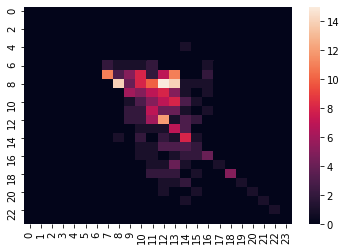

In [595]:
def time_in_hours(pd_datetime_series):
    return (pd_datetime_series - pd_datetime_series.dt.floor('D')).astype('timedelta64[h]')

temp = np.histogram2d(
    time_in_hours(shift_df.start),
    time_in_hours(shift_df.start + (shift_df.shift_periods * input_df.index.freq)),
    bins=24,
    range=((0, 23), (0, 23))
)[0]
sns.heatmap(temp)

Shifted by -1 days +20:20:00


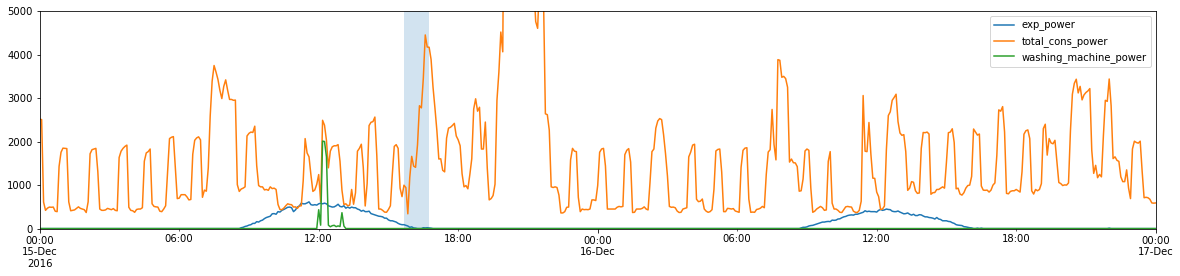

In [621]:
active_area = shift_df.sample().iloc[0]
if active_area.shift_periods:
    print('Shifted by {}'.format(pd.to_timedelta(active_area.shift_periods * input_df.index.freq)))
else:
    print('Not shifted')
preview_area = (pd.Timestamp(active_area.start).floor('d'), pd.Timestamp(active_area.start).ceil('d') + pd.Timedelta(1, 'd'))
p = modified_df.loc[preview_area[0]:preview_area[1], ['exp_power', 'total_cons_power', appliance_column]].plot(figsize=(20, 4), ylim=(0, 5000))
p.axvspan(active_area[0], active_area[1], alpha=0.2)

# Upper bound for improvement
Calculate an upper bound for the self-consumption we can achieve by load-shifting an appliance. Just assume that any power used by the appliance will be self consumed.

In [597]:
def calc_self_consumption_bound(df, consumed_column='total_cons_power', produced_column='exp_power', appliance_columns=all_appliance_columns):
    df = df.copy()
    consumed_by_appliances = df[appliance_columns].sum().sum()
    df[consumed_column] -= df[appliance_columns].sum(axis=1)
    df[appliance_columns] = 0
    return (df[[consumed_column, produced_column]].min(axis=1).sum() + consumed_by_appliances) / df[produced_column].sum()

In [598]:
print("Self-consumption was {:.2f}% and the upper bound is {:.2f}%".format(
    100 * calc_self_consumption(input_df[[consumed_column,produced_column,appliance_column]].dropna()),
    100 * calc_self_consumption_bound(input_df),
))

Self-consumption was 26.50% and the upper bound is 28.86%


In [678]:
temp=input_df.assign(time=input_df.index)
temp.time = pd.to_datetime(temp.time)
temp.index.month.min()

1

In [665]:
sommer = temp.loc[[t for t in temp.index if t.month in range(6,9)]]

In [679]:
sommer['2018'].iloc[-1]

audio_wlan_og_power                             15.524
dishwasher_power                                65.646
exp_power                                            0
hp_power                                             0
total_cons_power                                   630
rainwater_power                                  4.348
tumble_dryer_power                                   0
washing_machine_power                            1.104
time                     2018-08-31T23:55:00.000000000
Name: 2018-08-31 23:55:00, dtype: object